In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import os
import shutil

In [2]:
import pyvisa
#import keyboard
import csv

In [3]:
##With HP E4432B signal generator, 
#wind-up of frequency & rfpower
#Claude created

# -*- coding: utf-8 -*-
"""
Created on Mon Dec 23 16:01:17 2024

@author: Admin
"""

##With HP E4432B signal generator, 
#wind-up of frequency
#Claude created

#import pyvisa
import re
import time

#rm = pyvisa.ResourceManager()
E4432B_address = "GPIB0::13::INSTR"
#instrument = rm.open_resource(E4432B_address)
#start_voltage=0
#step_size=0.02
#delay=0.1
def open_resource(resource_id):
    rm = pyvisa.ResourceManager()
    return rm.open_resource(resource_id)

def present_freq(instrument):
    try:
        response = instrument.query("FREQ?")  # Note the '?' to query the value
        #match = re.search(r'([+-]?\d+\.\d+)', response)
        match = re.search(r'([+-]?\d+\.\d+E[+-]\d+)', response)
        if match:
            return float(match.group(1))
        else:
            raise ValueError(f"Unexpected response format: {response}")
    except Exception as e:
        print(f"Error retrieving freq: {e}")
        return None

def windup_freq(instrument, start_voltage, step_size, delay):
    present_voltage_val = present_freq(instrument)
    step_size = abs(step_size) if present_voltage_val < start_voltage else -abs(step_size)
    while abs(present_voltage_val - start_voltage) > abs(step_size) / 2:
        new_voltage = present_voltage_val + step_size
        new_voltage = start_voltage if (step_size > 0 and new_voltage > start_voltage) or (step_size < 0 and new_voltage < start_voltage) else new_voltage
        #instrument.write(f"S{new_voltage:.6f}E")
        instrument.write(f'FREQ {new_voltage}')
        print(f"Wind-up freq to: {new_voltage:.3f} Hz")
        #print(f"Power increased from {current_power:.3f} dBm to {new_power:.3f} dBm")
        time.sleep(delay)
        present_voltage_val = present_freq(instrument)
    instrument.write(f'FREQ{start_voltage}')
    print(f"Final freq set to: {start_voltage:.3f} Hz")
    
def present_Prf(instrument):
    try:
        response = instrument.query("POW?")  # Note the '?' to query the value
        #match = re.search(r'([+-]?\d+\.\d+)', response)
        match = re.search(r'([+-]?\d+\.\d+E[+-]\d+)', response)
        if match:
            return float(match.group(1))
        else:
            raise ValueError(f"Unexpected response format: {response}")
    except Exception as e:
        print(f"Error retrieving power: {e}")
        return None

def windup_Prf(instrument, start_voltage, step_size, delay):
    present_voltage_val = present_Prf(instrument)
    step_size = abs(step_size) if present_voltage_val < start_voltage else -abs(step_size)
    while abs(present_voltage_val - start_voltage) > abs(step_size) / 2:
        new_voltage = present_voltage_val + step_size
        new_voltage = start_voltage if (step_size > 0 and new_voltage > start_voltage) or (step_size < 0 and new_voltage < start_voltage) else new_voltage
        #instrument.write(f"S{new_voltage:.6f}E")
        instrument.write(f'POW {new_voltage}')
        print(f"Wind-up power to: {new_voltage:.3f} dBm")
        #print(f"Power increased from {current_power:.3f} dBm to {new_power:.3f} dBm")
        time.sleep(delay)
        present_voltage_val = present_Prf(instrument)
    instrument.write(f'POW{start_voltage}')
    print(f"Final voltage set to: {start_voltage:.3f} dBm")
    


def main():

    instrument = open_resource(E4432B_address) #rf source
    

    start_voltage5, step_size5, delay5 = -5, 1, 0.2  #Prf
    start_voltage6, step_size6, delay6 = 3e8, 1e7, 0.2  #freq


    windup_Prf(instrument, start_voltage5, step_size5, delay5) #Prf
    windup_freq(instrument, start_voltage6, step_size6, delay6)#freq

    voltage5 = present_Prf(instrument)
    voltage6 = present_freq(instrument)

    print(f"frequency: {voltage5:.6f} Hz")
    print(f"power: {voltage6:.3f} dBM")
    



if __name__ == "__main__":
    main()


Wind-up power to: -9.000 dBm
Wind-up power to: -8.000 dBm
Wind-up power to: -7.000 dBm
Wind-up power to: -6.000 dBm
Wind-up power to: -5.000 dBm
Final voltage set to: -5.000 dBm
Wind-up freq to: 490000000.000 Hz
Wind-up freq to: 480000000.000 Hz
Wind-up freq to: 470000000.000 Hz
Wind-up freq to: 460000000.000 Hz
Wind-up freq to: 450000000.000 Hz
Wind-up freq to: 440000000.000 Hz
Wind-up freq to: 430000000.000 Hz
Wind-up freq to: 420000000.000 Hz
Wind-up freq to: 410000000.000 Hz
Wind-up freq to: 400000000.000 Hz
Wind-up freq to: 390000000.000 Hz
Wind-up freq to: 380000000.000 Hz
Wind-up freq to: 370000000.000 Hz
Wind-up freq to: 360000000.000 Hz
Wind-up freq to: 350000000.000 Hz
Wind-up freq to: 340000000.000 Hz
Wind-up freq to: 330000000.000 Hz
Wind-up freq to: 320000000.000 Hz
Wind-up freq to: 310000000.000 Hz
Wind-up freq to: 300000000.000 Hz
Final freq set to: 300000000.000 Hz
frequency: -5.000000 Hz
power: 300000000.000 dBM


In [4]:
class Info:
    icase = 6
    icmd = 1
    a0 = -20.
    a1 = 20.
    b0 = -20.
    b1 = 20.
    ndim = 2
    ntrain0 = 36
    nn1 = 200
    nn2 = 200
    tolsig = 1e-3
    models12 = False
    rm = None
    yokogawa = None
    yokogawa2 = None
    multimeter = None

In [5]:
class GP():
    def __init__(self, ndim):
        self.ndim = ndim
        if True:
            #    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
            self.kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * \
                RBF(1.0, length_scale_bounds="fixed")
        else:
            self.kernel = DotProduct() + WhiteKernel()
        self.gp = GaussianProcessRegressor(
            kernel=self.kernel, n_restarts_optimizer=0)

    def train0(self):
        ntrain1 = 0
        if os.path.isfile('accum.txt'):
            afile = open('accum.txt', 'r')
            for line in afile:
                ntrain1 = ntrain1+1
            afile.close()
            X = np.zeros((ntrain1, self.ndim))
            y = np.zeros(ntrain1)
            i = 0
            afile = open('accum.txt', 'r')
            for line in afile:
                for j in range(self.ndim):
                    X[i, j] = float(line.split()[j])
                y[i] = float(line.split()[-1])
                i = i+1
            afile.close()
            self.gp.fit(X, y)
            del X, y, ntrain1, i, j, line

    def predict(self, X_test):
        y_pred, y_std = self.gp.predict(X_test, return_std=True)
        return y_pred, y_std

    def tpredict(self, X_test):
        ntrain01 = 0
        if os.path.isfile('accum.txt'):
            afile = open('accum.txt', 'r')
            for line in afile:
                ntrain01 = ntrain01+1
            afile.close()
            X = np.zeros((ntrain01, self.ndim))
            y = np.zeros(ntrain01)
            i = 0
            afile = open('accum.txt', 'r')
            for line in afile:
                for j in range(self.ndim):
                    X[i, j] = float(line.split()[j])
                y[i] = float(line.split()[-1])
                i = i+1
            afile.close()
            ntrain1 = i
            self.gp.fit(X, y)
            del X, y, i, ntrain1, line, ntrain01, j
        y_pred, y_std = self.gp.predict(X_test, return_std=True)
        return y_pred, y_std

In [6]:
class Multi_knn():
    def __init__(self, ndim, models12):
        self.ndim = ndim
        self.models12 = models12
        self.knn4 = KNeighborsRegressor(
            n_neighbors=4, leaf_size=30, p=2,  weights='distance')
        self.knn5 = KNeighborsRegressor(
            n_neighbors=5, leaf_size=30, p=2,  weights='distance')
        self.knn6 = KNeighborsRegressor(
            n_neighbors=6, leaf_size=30, p=2,  weights='distance')
        self.knn7 = KNeighborsRegressor(
            n_neighbors=7, leaf_size=30, p=2,  weights='distance')
        self.knn8 = KNeighborsRegressor(
            n_neighbors=8, leaf_size=30, p=2,  weights='distance')
        self.knn9 = KNeighborsRegressor(
            n_neighbors=9, leaf_size=30, p=2,  weights='distance')
        if models12:
            self.knn41 = KNeighborsRegressor(
                n_neighbors=4, leaf_size=30, p=1.5, weights='distance')
            self.knn51 = KNeighborsRegressor(
                n_neighbors=5, leaf_size=30, p=1.5, weights='distance')
            self.knn61 = KNeighborsRegressor(
                n_neighbors=6, leaf_size=30, p=1.5, weights='distance')
            self.knn71 = KNeighborsRegressor(
                n_neighbors=7, leaf_size=30, p=1.5, weights='distance')
            self.knn81 = KNeighborsRegressor(
                n_neighbors=8, leaf_size=30, p=1.5, weights='distance')
            self.knn91 = KNeighborsRegressor(
                n_neighbors=9, leaf_size=30, p=1.5, weights='distance')

    def train0(self):
        ntrain1 = 0
        if os.path.isfile('accum.txt'):
            afile = open('accum.txt', 'r')
            for line in afile:
                ntrain1 = ntrain1+1
            afile.close()
            X = np.zeros((ntrain1, self.ndim))
            y = np.zeros(ntrain1)
            i = 0
            afile = open('accum.txt', 'r')
            for line in afile:
                for j in range(self.ndim):
                    X[i, j] = float(line.split()[j])
                y[i] = float(line.split()[-1])
                i = i+1
            afile.close()
            self.knn4.fit(X, y)
            self.knn5.fit(X, y)
            self.knn6.fit(X, y)
            self.knn7.fit(X, y)
            self.knn8.fit(X, y)
            self.knn9.fit(X, y)
            if self.models12:
                self.knn41.fit(X, y)
                self.knn51.fit(X, y)
                self.knn61.fit(X, y)
                self.knn71.fit(X, y)
                self.knn81.fit(X, y)
                self.knn91.fit(X, y)
            del X, y, ntrain1, i, j, line

    def predict(self, X_test):
        anarray = []
        ypred = self.knn4.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn5.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn6.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn7.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn8.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn9.predict(X_test)
        anarray.append(ypred)
        if self.models12:
            ypred = self.knn41.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn51.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn61.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn71.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn81.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn91.predict(X_test)
            anarray.append(ypred)
        anarray = np.array(anarray)
        return np.mean(anarray), np.std(anarray)

    def tpredict(self, X_test):
        ntrain01 = 0
        if os.path.isfile('accum.txt'):
            afile = open('accum.txt', 'r')
            for line in afile:
                ntrain01 = ntrain01+1
            afile.close()
            X = np.zeros((ntrain01, self.ndim))
            y = np.zeros(ntrain01)
            i = 0
            afile = open('accum.txt', 'r')
            for line in afile:
                for j in range(self.ndim):
                    X[i, j] = float(line.split()[j])
                y[i] = float(line.split()[-1])
                i = i+1
            afile.close()
            ntrain1 = i
            self.knn4.fit(X, y)
            self.knn5.fit(X, y)
            self.knn6.fit(X, y)
            self.knn7.fit(X, y)
            self.knn8.fit(X, y)
            self.knn9.fit(X, y)
            if self.models12:
                self.knn41.fit(X, y)
                self.knn51.fit(X, y)
                self.knn61.fit(X, y)
                self.knn71.fit(X, y)
                self.knn81.fit(X, y)
                self.knn91.fit(X, y)
            del X, y, ntrain1, ntrain01, i, j, line
        anarray = []
        ypred = self.knn4.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn5.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn6.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn7.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn8.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn9.predict(X_test)
        anarray.append(ypred)
        if self.models12:
            ypred = self.knn41.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn51.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn61.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn71.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn81.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn91.predict(X_test)
            anarray.append(ypred)
        anarray = np.array(anarray)
        return np.mean(anarray), np.std(anarray)

In [7]:
def append_new_line(file_name, text_to_append):
    with open(file_name, "a+") as file_object:
        file_object.seek(0)
        data = file_object.read(100)
        if len(data) > 0:
            file_object.write("\n")
        file_object.write(text_to_append)


def append_multiple_lines(file_name, lines_to_append):
    with open(file_name, "a+") as file_object:
        appendEOL = False
        file_object.seek(0)
        data = file_object.read(100)
        if len(data) > 0:
            appendEOL = True
        for line in lines_to_append:
            if appendEOL == True:
                file_object.write("\n")
            else:
                appendEOL = True
            file_object.write(line)

In [8]:
def afun0(x, y):
    icase = Info.icase
    if icase == 0:
        tmp = np.exp(-((x-0.)/4.)**2-((y-0.)/2)**2)
    if icase == 1:
        tmq = np.exp(-((x-0.)/3.)**2-((y-0.)/2.)**2)
        tmp = np.sin(x+y)+(x-y)**2-1.5*x+2.5*y + 1
        tmp = tmp * tmq
    if icase == 11:
        tmq = np.exp(-((x-0.)/4)**2-((y-0.)/2)**2)
        tmp = (1.5-x+x*y)**2 + (2.25-x+x*y**2)**2 + (2.625-x+x*y**3)**2
        tmp = tmp * tmq
    if icase == 2:
        tmq = np.exp(-((x-0.)/4.)**2-((y-0.)/2)**2)
        tmp = -20.*np.exp(-0.2*np.sqrt(0.5*(x**2+y**2)))-np.exp(0.5 *
                                                                (np.cos(np.pi*2*x)+np.cos(np.pi*2*y)))+np.exp(1.)+20.
        tmp = tmp * tmq
    if icase == 3:
        tmq = np.exp(-((x-0.)/4)**2-((y-0.)/2)**2)
        tmp = (1.+(x+y+1)**2 * (19.-14*x+3.*x**2-14*y + 6*x*y+3*y**2)) * \
            (30.+(2*x-3*y)**2 * (18-32*x+12*x**2 + 48*y - 36*x*y + 27*y**2))
        tmp = tmp * tmq
    if icase == 4:
        tmq = np.exp(-((x-0.)/4)**2-((y-0.)/2)**2)
        tmp = (x**2 + y-11)**2 + (x+y**2-7)**2
        tmp = tmp * tmq
    if icase == 5:
        tmq = np.exp(-((x-0.)/4)**2-((y-0.)/2)**2)
        tmp = (x**4 - 16*x**2 + 5*x + y**4 - 16*y**2 + 5*y)/2.
        tmp = tmp * tmq
    if icase == 6:
        tmp = np.cos(0.1*x) * np.cos(0.2*y)
    if icase == 7:
        tmp = np.sin(0.1*x) ** 2 + np.cos(0.2*y) ** 2
    if icase == 8:
        tmp = np.cos(0.1*x + np.sin(0.2*y))
    if icase == 9:
        tmp = np.cos(0.1*x) + np.sin(0.2*y)
    if icase == 10:
        r = np.sqrt(x**2+y**2)
        if r < 1e-10:
            tmp = 1.
        else:
            tmp = np.sin(r)/r
    return tmp

In [9]:
def afun(x, y):
    Info.yokogawa.write(f'S{x:0.5f}E')
    Info.yokogawa2.write(f'S{y:0.5f}E')
    time.sleep(0.1)
    tmp = float(Info.multimeter.query("READ?"))
    return tmp

In [10]:
def driver1():
    print(Info.ndim, ' dimensions')
    if Info.ndim == 2:
        print(Info.a0, Info.a1, Info.b0, Info.b1, ' boundary parameters')
        print(Info.nn1, Info.nn2, Info.tolsig, ' n1, n2, tolsig')
    print(Info.ntrain0, ' initial points')

    start = time.time()
    if Info.ndim == 2:
        a0 = Info.a0
        a1 = Info.a1
        b0 = Info.b0
        b1 = Info.b1
        nn1 = Info.nn1
        nn2 = Info.nn2
        itest = np.zeros((nn1, nn2))

    ndim = Info.ndim
    ntrain0 = Info.ntrain0
    tolsig = Info.tolsig
    models12 = Info.models12
    ntrain = ntrain0

    if os.path.isfile('accum.txt'):
        fname = 'accum_'+str(np.random.randint(1000000))+'.txt'
        shutil.copyfile('accum.txt', fname)
        os.remove('accum.txt')
    X_train = np.zeros((ntrain0, ndim))
    y_train = np.zeros(ntrain0)
    if ndim == 2:
        alist = []
        blist = []
        iskip = np.sqrt(float(nn1*nn2) / ntrain0)
        iskip = int(iskip)
        if iskip < 1:
            iskip = 1
        i = 0
        for ii in range(0, nn1, iskip):
            for jj in range(0, nn2, iskip):
                if i < ntrain0:
                    alist.append((a1-a0)*float(ii)/float(nn1-1)+a0)
                    blist.append((b1-b0)*float(jj)/float(nn2-1)+b0)
                i = i + 1
        for i in range(ntrain0):
            X_train[i, 0] = alist[i]
            X_train[i, 1] = blist[i]
            y_train[i] = afun(X_train[i, 0], X_train[i, 1])
            lines_to_append = []
            astring = ''
            for j in range(ndim):
                astring = astring+' '+str(X_train[i, j])
            astring = astring+' '+str(y_train[i])
            lines_to_append.append(astring)
            append_multiple_lines('accum.txt', lines_to_append)
        print('coarse', ntrain0)
    else:
        print('not yet')
        for i in range(ntrain0):
            for j in range(ndim):
                X_train[i, j] = np.random.random()
            y_train[i] = 1.

    if Info.icmd == 1:
        multi = Multi_knn(ndim, models12)
        if models12:
            print('Multi_knn', 12)
        else:
            print('Multi_knn', 6)
    else:
        multi = GP(ndim)
        print('GP')
    multi.train0()
    print('train0: the first training')
    X_test = np.zeros((1, ndim))
    for iskip in range(33, 1, -1):
        for ii in range(0, nn1, iskip):
            alist = []
            for jj in range(0, nn2, iskip):
                alist.append(jj)
            if ii % 2 == 1:
                alist.reverse()
            for jj in alist:
                if ndim == 2:
                    X_test[0, 0] = (a1-a0)*float(ii)/float(nn1-1)+a0
                    X_test[0, 1] = (b1-b0)*float(jj)/float(nn2-1)+b0
                    y_pred, y_std = multi.predict(X_test)
                else:
                    print('not yet')
                if y_std < tolsig:
                    tmp = y_pred
                else:
                    itest[ii, jj] = 1.
                    ntrain = ntrain + 1
                    tmp = afun(X_test[0, 0], X_test[0, 1])
                    lines_to_append = []
                    astring = ''
                    for j in range(ndim):
                        astring = astring+' '+str(X_test[0, j])
                    astring = astring+' '+str(tmp)
                    lines_to_append.append(astring)
                    append_multiple_lines('accum.txt', lines_to_append)
                    y_pred, y_std = multi.tpredict(X_test)
    print(ntrain, nn1*nn2, float(ntrain)/float(nn1*nn2))
    if True:
        mm1 = nn1*1
        mm2 = nn2*1
        mm1 = int(mm1)
        mm2 = int(mm2)
    print(ntrain, mm1*mm2, float(ntrain)/float(mm1*mm2))
    b = np.arange(a0, a1, (a1-a0)/mm1)
    d = np.arange(b0, b1, (b1-b0)/mm2)
    B, D = np.meshgrid(b, d)
    n, m = B.shape
    print(n, m)
    nu = np.zeros((n, m))
    st = np.zeros((n, m))
    X_test = np.zeros((1, ndim))
    for i in range(n):
        for j in range(m):
            X_test[0, 0] = B[i, j]
            X_test[0, 1] = D[i, j]
            y_pred, y_std = multi.predict(X_test)
            nu[i, j] = y_pred
            st[i, j] = y_std
    end = time.time()
    print(end - start, (end-start)/60.)

    start = time.time()
    fig = plt.figure(figsize=(12, 12))
    #ax = Axes3D(fig)
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(B, D, nu)
    plt.xlabel('$V_1$ (V)', fontsize=22, labelpad=10)
    plt.ylabel('$V_2$ (V)', fontsize=22, labelpad=10)
    ax.set_zlabel('Current (10nA)', fontsize=22, rotation=0, labelpad=16)
    plt.savefig('mean.pdf')
    plt.show()
    plt.close()

    fig = plt.figure(figsize=(12, 12))
    #ax = Axes3D(fig)
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(B, D, st)
    plt.xlabel('$V_1$ (V)', fontsize=22, labelpad=10)
    plt.ylabel('$V_2$ (V)', fontsize=22, labelpad=10)
    ax.set_zlabel('Std. Dev. in Current (10nA)',
                  fontsize=18, rotation=0, labelpad=14)
    plt.savefig('std.pdf')
    plt.show()
    plt.close()

    fig = plt.figure(figsize=(12, 12))
    #ax = Axes3D(fig)
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(B, D, nu)
    ax.view_init(elev=10., azim=100.)
    plt.xlabel('$V_1$ (V)', fontsize=22, labelpad=10)
    plt.ylabel('$V_2$ (V)', fontsize=22, labelpad=10)
    ax.set_zlabel('Current (10nA)', fontsize=22, rotation=0, labelpad=16)
    plt.savefig('mean1.pdf')
    plt.show()
    plt.close()

    fig = plt.figure(figsize=(12, 12))
    #ax = Axes3D(fig)
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(B, D, st)
    ax.view_init(elev=10., azim=100.)
    plt.xlabel('$V_1$ (V)', fontsize=22, labelpad=10)
    plt.ylabel('$V_2$ (V)', fontsize=22, labelpad=10)
    ax.set_zlabel('Std. Dev. in Current (10nA)',
                  fontsize=22, rotation=0, labelpad=16)
    plt.savefig('std1.pdf')
    plt.show()
    plt.close()

    result = st.flatten()
    fig = plt.figure(figsize=(12, 8))
    plt.rcParams["xtick.minor.visible"] = True
    plt.rcParams["ytick.minor.visible"] = True
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.hist(result, bins=25, color='skyblue', edgecolor='black')
    plt.xlabel('Standard deviation', fontsize=22)
    plt.ylabel('Frequency (arb. unit)', fontsize=22)
    plt.yscale('log')
    plt.xticks(fontsize=16)
#    plt.yticks(fontsize=19, rotation=0)
#    plt.tick_params(axis='both', which='major', labelsize=12)
#    plt.rc('xtick',labelsize=18)
#    plt.rc('ytick',labelsize=22)
    plt.tight_layout()
    plt.savefig('sig_dist_knn.pdf')
    plt.show()
    plt.close()
    print(np.mean(result), np.std(result))

    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_aspect(1.)
    coords = np.argwhere(itest == 1)
    plt.xlim(0, mm1)
    plt.ylim(0, mm2)
    plt.scatter(coords[:, 0], coords[:, 1], s=0.1,
                facecolors='none', edgecolors='r')
    plt.tight_layout()
    plt.savefig("sampled_knn.pdf")
    plt.show()
    plt.close()
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12

    fig = plt.figure(figsize=(12, 12))
    #ax = Axes3D(fig)
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(B, D, nu)
    ax.view_init(elev=15., azim=120.)
    plt.xlabel('$V_1$ (V)', fontsize=22, labelpad=10)
    plt.ylabel('$V_2$ (V)', fontsize=22, labelpad=10)
    ax.set_zlabel('Current (10nA)', fontsize=22, rotation=0, labelpad=16)
    plt.savefig('mean2.pdf')
    plt.show()
    plt.close()

    fig = plt.figure(figsize=(12, 12))
    #ax = Axes3D(fig)
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(B, D, st)
    ax.view_init(elev=15., azim=120.)
    plt.xlabel('$V_1$ (V)', fontsize=22, labelpad=10)
    plt.ylabel('$V_2$ (V)', fontsize=22, labelpad=10)
    ax.set_zlabel('Std. Dev. in Current (10nA)',
                  fontsize=22, rotation=0, labelpad=16)
    plt.savefig('std2.pdf')
    plt.show()
    plt.close()

    fig, ax = plt.subplots()
    CS = ax.contour(B, D, nu)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_aspect('equal', 'box')
    #ax.set_title('Simplest default with labels')
    plt.tight_layout()
    plt.savefig('mean_c.pdf')
    plt.show()
    plt.close()

    fig, ax = plt.subplots()
    CS = ax.contour(B, D, st)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_aspect('equal', 'box')
    #ax.set_title('Simplest default with labels')
    plt.tight_layout()
    plt.savefig('std_c.pdf')
    plt.show()
    plt.close()

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    ax1.set_aspect('equal', 'box')
    ax2.set_aspect('equal', 'box')
    amax = np.max(nu)
    amin = np.min(nu)
    print(amin, amax)
    tmz = (amax-amin)/10.
    ax1.contourf(nu, levels=np.arange(amin, amax, tmz),
                 extend='both', origin="lower")
    amax = np.max(st)
    amin = np.min(st)
    print(amin, amax)
    tmz = (amax-amin)/10.
    ax2.contourf(st, levels=np.arange(amin, amax, tmz),
                 extend='both', origin="lower")
    plt.savefig('mean_std.pdf')
    plt.show()
    plt.close()
    end = time.time()
    print(end - start, (end-start)/60.)

main program below

('GPIB0::2::INSTR', 'GPIB0::5::INSTR', 'GPIB0::6::INSTR', 'GPIB0::7::INSTR', 'GPIB0::11::INSTR', 'GPIB0::13::INSTR', 'GPIB0::22::INSTR')
2  dimensions
-0.4 -0.0 -0.4 -0.0  boundary parameters
200 200 0.001  n1, n2, tolsig
36  initial points
coarse 36
Multi_knn 6
train0: the first training
3129 40000 0.078225
3129 40000 0.078225
200 200
826.0089509487152 13.766815849145253


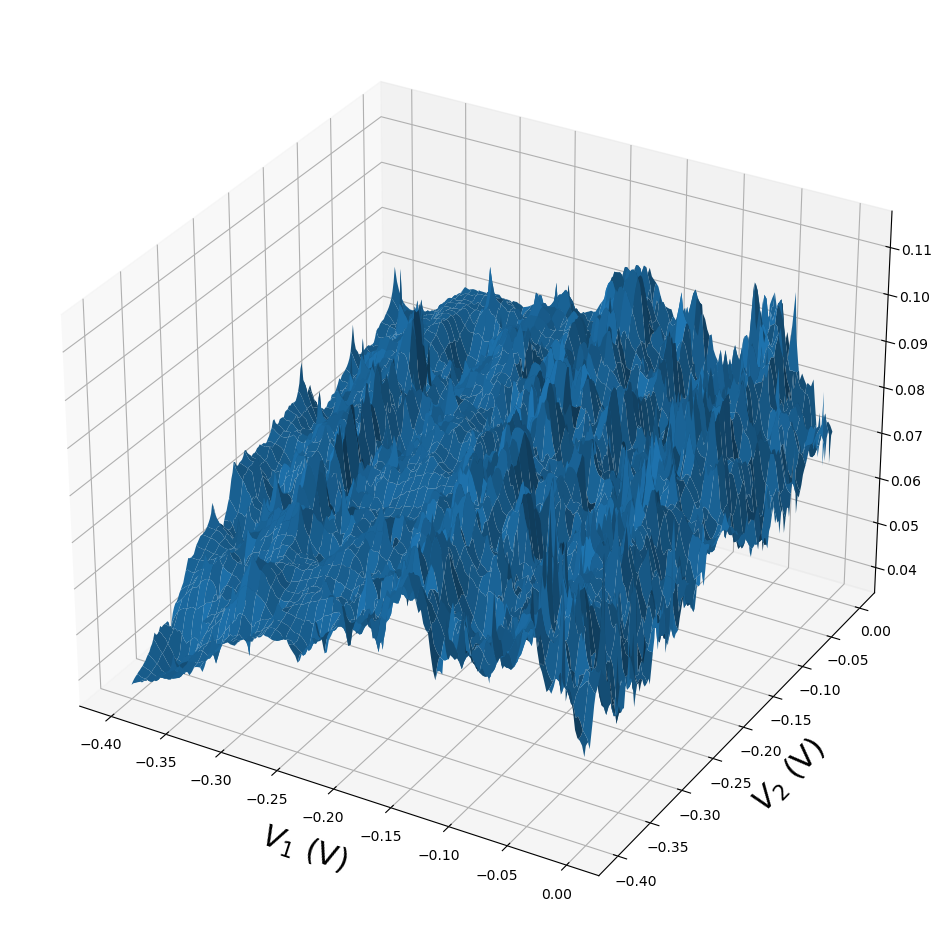

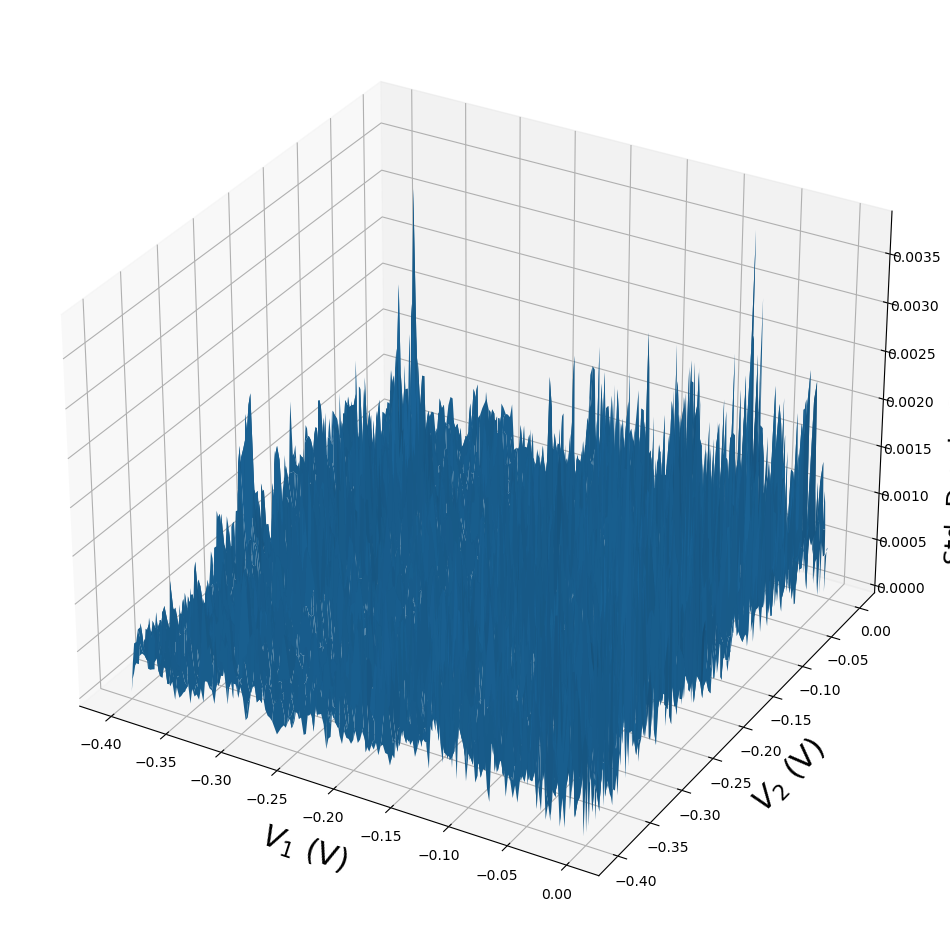

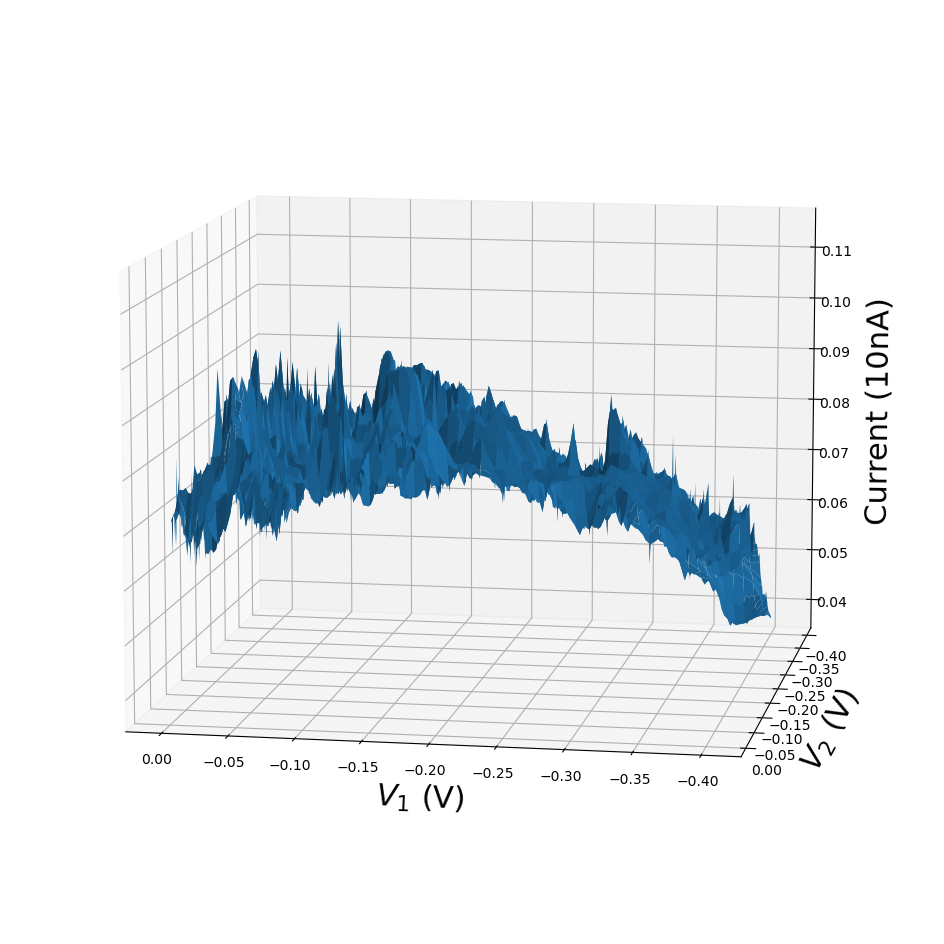

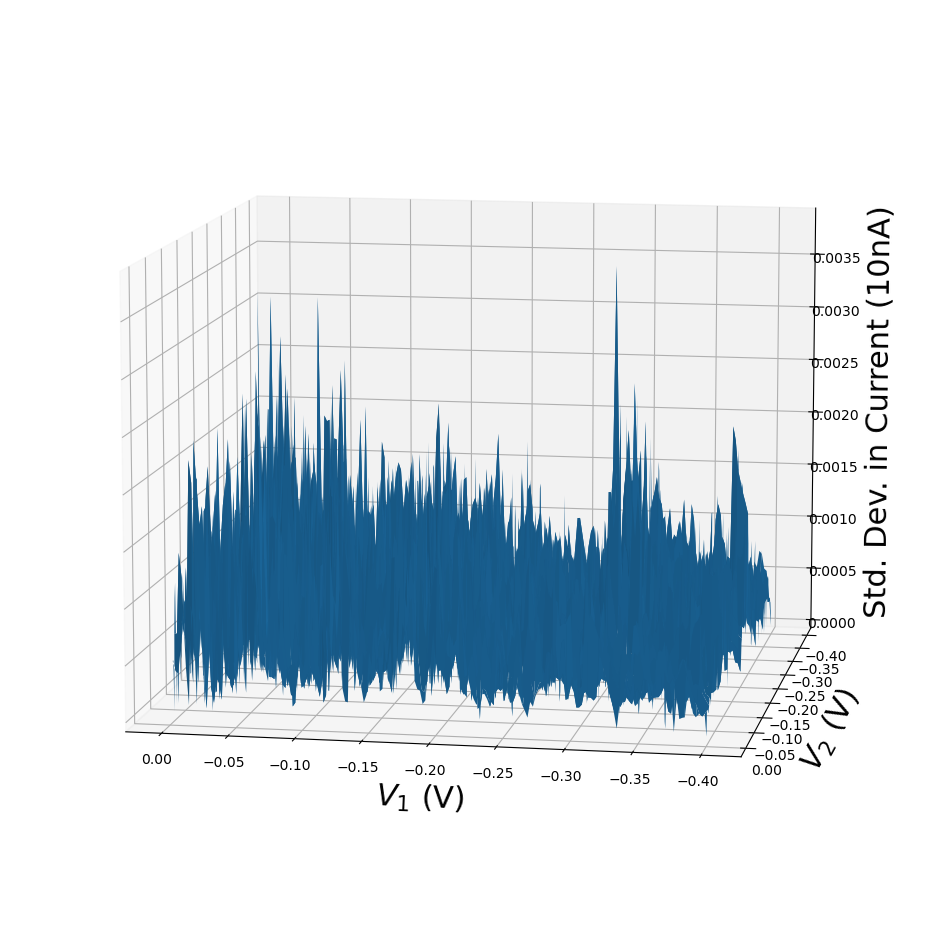

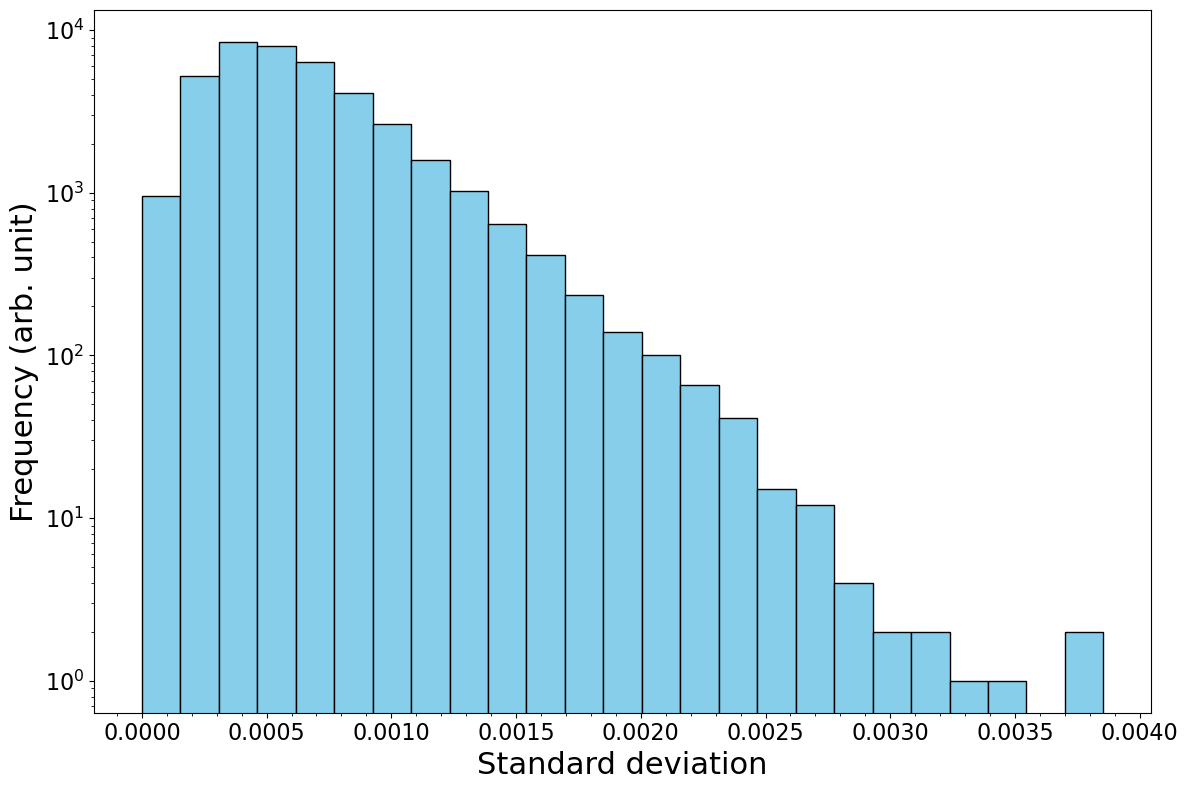

0.0006355836857128806 0.0003606433679061171


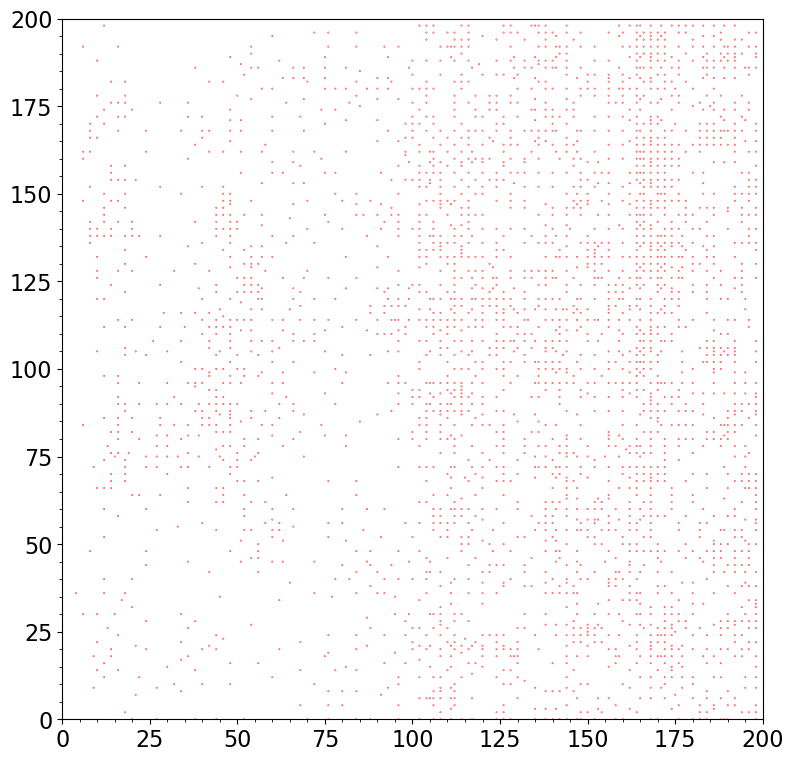

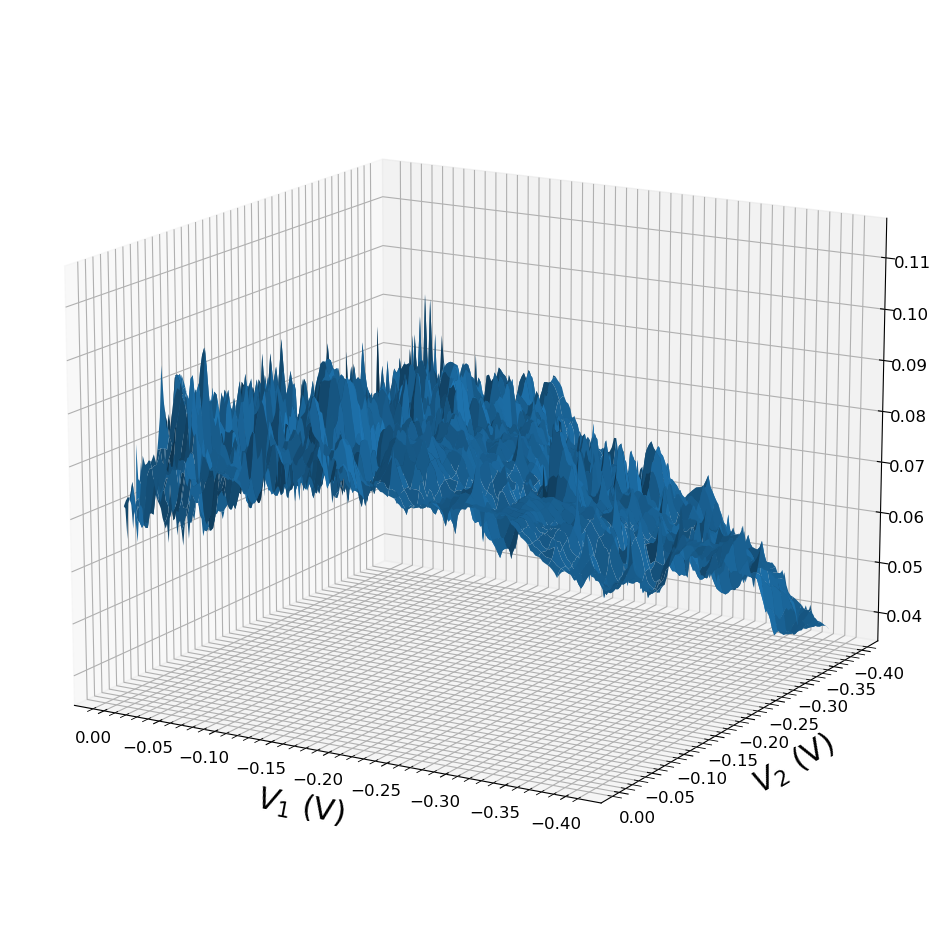

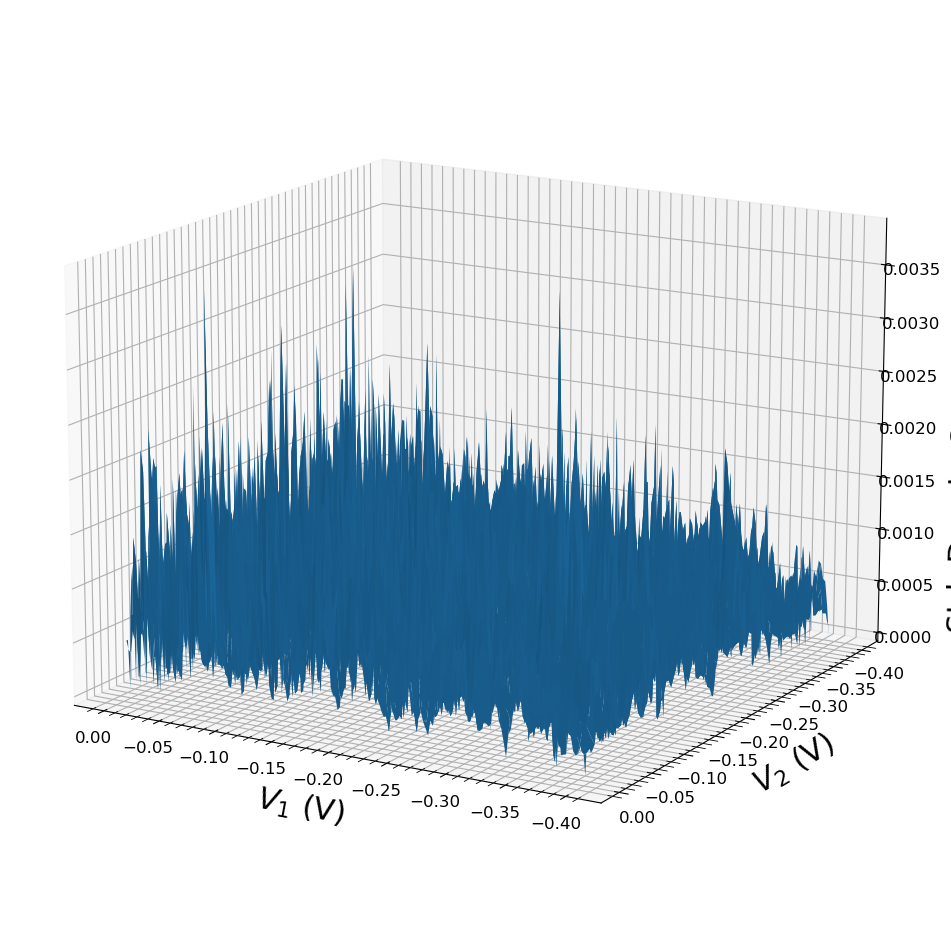

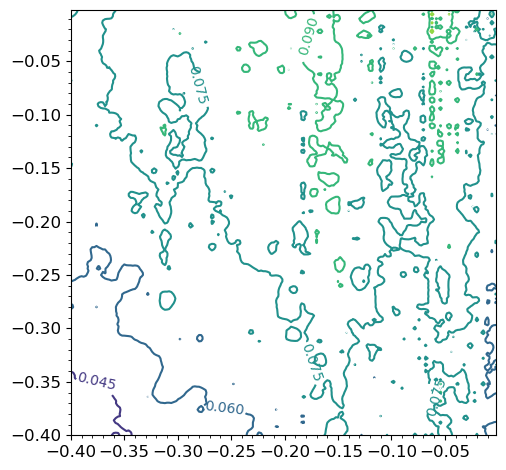

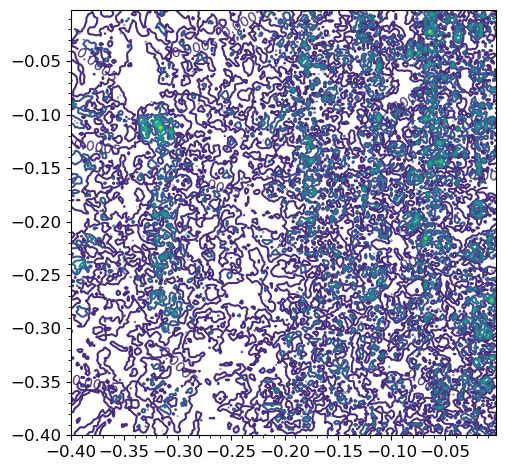

0.035937669637516594 0.11598373209299995
0.0 0.003854145519801998


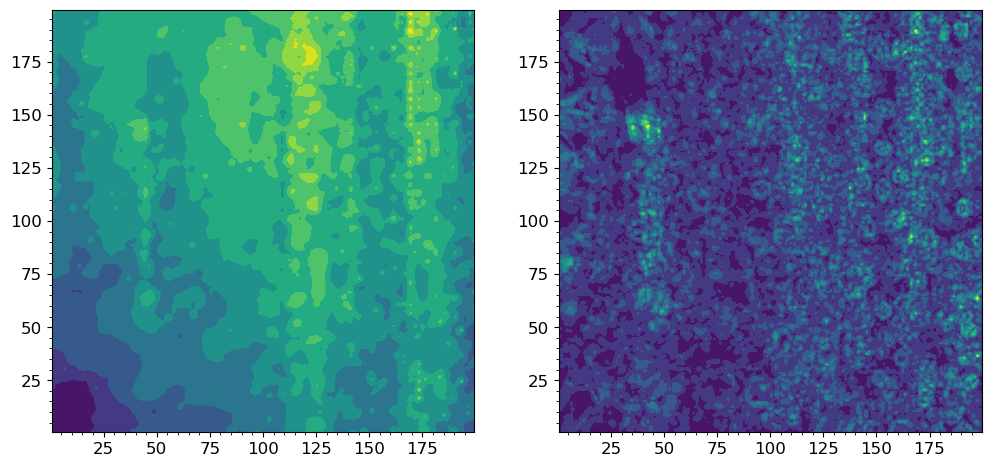

19.25999164581299 0.3209998607635498


In [11]:
Info.a0 = -20.
Info.a1 = 20.
Info.b0 = -20.
Info.b1 = 20.
Info.tolsig= 1e-3

if True:
    Info.a0 = -0.4
    Info.a1 = -0.0
    Info.b0 = -0.4
    Info.b1 = -0.

Info.ntrain0 = 36
Info.nn1 = 200
Info.nn2 = 200



if True:
    Info.rm = pyvisa.ResourceManager()
    print(Info.rm.list_resources())
    Info.yokogawa = Info.rm.open_resource(
        "GPIB0::11::INSTR", write_termination='\n', read_termination='\n')
    Info.multimeter = Info.rm.open_resource(
        "GPIB0::22::INSTR", write_termination='\n', read_termination='\n')
    Info.yokogawa2 = Info.rm.open_resource(
        "GPIB0::7::INSTR", write_termination='\n', read_termination='\n')
    Info.yokogawa.write("F1R5O1E")
    Info.yokogawa2.write("F1R5O1E")

driver1()